In [15]:
import os
import random
import shutil

from multiprocessing.dummy import Pool

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

from sklearn.model_selection import train_test_split
import joblib

from skimage.morphology import binary_opening, disk, label

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

import torchvision.transforms as transforms

# Семнатическая сегментация

В рамках данного ноутбука мы будем решать задачу по мотивам https://www.kaggle.com/competitions/airbus-ship-detection

В исходной задаче необходимо детектировать корабли, мы же будем проводить сегентмацию. Мы также упростим задачу с точки зрения рамезра изображений, чтобы получить необходимый нам учебный результат за размумное время.

# Генерация датасета кружочков и масок


In [16]:
import numpy as np
from PIL import Image

class BaseDataProvider(object):
    channels = 1
    n_class = 2

    def __init__(self, a_min=None, a_max=None):
        self.a_min = a_min if a_min is not None else -np.inf
        self.a_max = a_max if a_min is not None else np.inf

    def _load_data_and_label(self):
        data, label = self._next_data()

        train_data = self._process_data(data)
        labels = self._process_labels(label)

        train_data, labels = self._post_process(train_data, labels)

        nx = train_data.shape[1]
        ny = train_data.shape[0]

        return train_data.reshape(1, ny, nx, self.channels), labels.reshape(1, ny, nx, self.n_class),

    def _process_labels(self, label):
        if self.n_class == 2:
            nx = label.shape[1]
            ny = label.shape[0]
            labels = np.zeros((ny, nx, self.n_class), dtype=np.float32)

            # It is the responsibility of the child class to make sure that the label
            # is a boolean array, but we a chech here just in case.
            if label.dtype != 'bool':
                label = label.astype(bool)

            labels[..., 1] = label
            labels[..., 0] = ~label
            return labels

        return label

    def _process_data(self, data):
        # normalization
        data = np.clip(np.fabs(data), self.a_min, self.a_max)
        data -= np.amin(data)

        if np.amax(data) != 0:
            data /= np.amax(data)

        return data

    def _post_process(self, data, labels):
        """
        Post processing hook that can be used for data augmentation
        :param data: the data array
        :param labels: the label array
        """
        return data, labels

    def __call__(self, n):
        train_data, labels = self._load_data_and_label()
        nx = train_data.shape[1]
        ny = train_data.shape[2]

        X = np.zeros((n, nx, ny, self.channels))
        Y = np.zeros((n, nx, ny, self.n_class))

        X[0] = train_data
        Y[0] = labels
        for i in range(1, n):
            train_data, labels = self._load_data_and_label()
            X[i] = train_data
            Y[i] = labels

        return X, Y

class GrayScaleDataProvider(BaseDataProvider):
    channels = 1
    n_class = 2

    def __init__(self, nx, ny, **kwargs):
        super(GrayScaleDataProvider, self).__init__()
        self.nx = nx
        self.ny = ny
        self.kwargs = kwargs
        rect = kwargs.get("rectangles", False)
        if rect:
            self.n_class=3

    def _next_data(self):
        return create_image_and_label(self.nx, self.ny, **self.kwargs)

class RgbDataProvider(BaseDataProvider):
    channels = 3
    n_class = 2

    def __init__(self, nx, ny, **kwargs):
        super(RgbDataProvider, self).__init__()
        self.nx = nx
        self.ny = ny
        self.kwargs = kwargs
        rect = kwargs.get("rectangles", False)
        if rect:
            self.n_class=3


    def _next_data(self):
        data, label = create_image_and_label(self.nx, self.ny, **self.kwargs)
        return to_rgb(data), label

def create_image_and_label(nx,ny, cnt = 10, r_min = 5, r_max = 50, border = 92, sigma = 20, rectangles=False):


    image = np.ones((nx, ny, 1))
    label = np.zeros((nx, ny, 3), dtype=bool)
    mask = np.zeros((nx, ny), dtype=bool)
    for _ in range(cnt):
        a = np.random.randint(border, nx-border)
        b = np.random.randint(border, ny-border)
        r = np.random.randint(r_min, r_max)
        h = np.random.randint(1,255)

        y,x = np.ogrid[-a:nx-a, -b:ny-b]
        m = x*x + y*y <= r*r
        mask = np.logical_or(mask, m)

        image[m] = h

    label[mask, 1] = 1

    if rectangles:
        mask = np.zeros((nx, ny), dtype=bool)
        for _ in range(cnt//2):
            a = np.random.randint(nx)
            b = np.random.randint(ny)
            r =  np.random.randint(r_min, r_max)
            h = np.random.randint(1,255)

            m = np.zeros((nx, ny), dtype=bool)
            m[a:a+r, b:b+r] = True
            mask = np.logical_or(mask, m)
            image[m] = h

        label[mask, 2] = 1

        label[..., 0] = ~(np.logical_or(label[...,1], label[...,2]))

    image += np.random.normal(scale=sigma, size=image.shape)
    image -= np.amin(image)
    image /= np.amax(image)

    if rectangles:
        return image, label
    else:
        return image, label[..., 1]




def to_rgb(img):
    img = img.reshape(img.shape[0], img.shape[1])
    img[np.isnan(img)] = 0
    img -= np.amin(img)
    img /= np.amax(img)
    blue = np.clip(4*(0.75-img), 0, 1)
    red  = np.clip(4*(img-0.25), 0, 1)
    green= np.clip(44*np.fabs(img-0.5)-1., 0, 1)
    rgb = np.stack((red, green, blue), axis=2)
    return rgb


In [17]:
def generate_circle_dataset(pic_number=6000, nx = 572, ny = 572, circle_cnt=20):
  generator = GrayScaleDataProvider(nx, ny, cnt=circle_cnt)
  circle_data, circle_mask_data = generator(pic_number)
  return circle_data, circle_mask_data

In [18]:
def show_circle_mask(img_df, mask_df, ind):
  fig, ax = plt.subplots(1,2, sharey=True, figsize=(8,4))
  ax[0].imshow(img_df[ind], aspect="auto")
  ax[1].imshow(mask_df[ind], aspect="auto")

## Подготовка набора данных

In [19]:
nx = 572
ny = 572

original_img_size = (nx, ny)

In [20]:
circle_data, circle_mask_data = generate_circle_dataset(100, nx, ny)
img_df = circle_data[..., 0]
mask_df = circle_mask_data[..., 1]

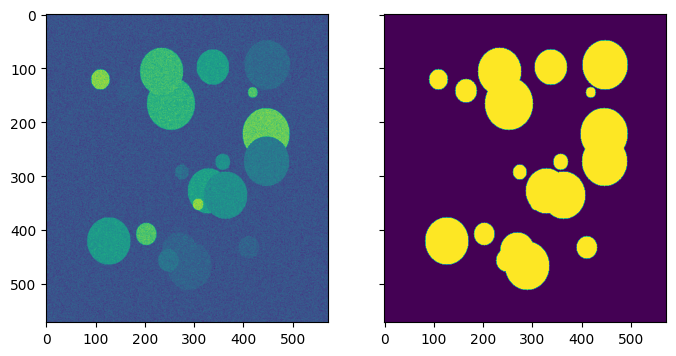

In [21]:
show_circle_mask(img_df, mask_df, 1)

In [22]:
img_df.shape

(100, 572, 572)

In [23]:
mask_df.shape

(100, 572, 572)

In [24]:
test_size = round(0.15 * img_df.shape[0])
train_imgs = img_df[:test_size]
train_mask = mask_df[:test_size]
val_imgs = img_df[test_size:]
val_mask = mask_df[test_size:]

In [25]:
train_imgs.shape, val_imgs.shape

((15, 572, 572), (85, 572, 572))

## Набор данных

Нам необходимо правильно переработать входные данные таким образом, чтобы изображения и маски совпадали в размерах и могли быть интерпретированны моделью машинного обучения. Для этого надо научиться читать формат данных файла.

In [26]:
class ImgDataset(Dataset):

    def __init__(self,
                 img_df,
                 img_transform,
                 mask_df,
                 mask_transform):
        self.img_df = img_df
        self.img_transform = img_transform

        self.mask_df = mask_df
        self.mask_transform = mask_transform

    def __getitem__(self, i):
        img = Image.fromarray(self.img_df[i])
        mask = Image.fromarray(self.mask_df[i])
        if self.img_transform is not None:
            img = self.img_transform(img)

        if self.mask_transform is not None:
            # print(self.mask_transform)
            mask = self.mask_transform(mask)
            mask.squeeze_()
        return img, mask

    def __len__(self):
        return len(self.img_df)

Получив набор данных, зададим необходимые ппраметы, в том числе уменьшим изображения до 80 х 80. Для решения задачи хвтит трёх эпох.

In [27]:
class param:
    img_size = (80, 80)
    bs = 8
    num_workers = 4
    lr = 0.001
    epochs = 10
    unet_depth = 5
    unet_start_filters = 8
    log_interval = 5 # less then len(train_dl)

In [28]:
train_tfms = transforms.Compose([transforms.Resize(param.img_size),
                                 transforms.ToTensor()])
val_tfms = transforms.Compose([transforms.Resize(param.img_size),
                               transforms.ToTensor()])
mask_tfms = transforms.Compose([transforms.Resize(param.img_size),
                                transforms.ToTensor(),
                                transforms.Lambda(lambda x: x.long()),
                                ])

In [29]:
train_ds = ImgDataset(train_imgs, train_tfms, train_mask, mask_tfms)
test_ds = ImgDataset(val_imgs, val_tfms, val_mask, mask_tfms)

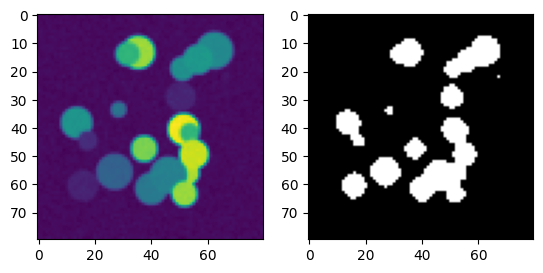

In [30]:
img, mask = train_ds[2]
plt.subplot(121)
plt.imshow(img.permute(1,2,0))
plt.subplot(122)
plt.imshow(mask, cmap="gray")
plt.show()

In [31]:
mask.shape

torch.Size([80, 80])

## Модель и её подготовка

Нам необходимо реализовать свёрточные и развёрточные слои. Для примера сделаем их сами.

In [32]:
def conv1x1(in_channels, out_channels, groups=1):
    return nn.Conv2d(in_channels,
                     out_channels,
                     kernel_size=1,
                     groups=groups,
                     stride=1)

def conv3x3(in_channels, out_channels, stride=1, padding=1, bias=True, groups=1):
    return nn.Conv2d(in_channels,
                     out_channels,
                     kernel_size=3,
                     stride=stride,
                     padding=padding,
                     bias=bias,
                     groups=groups)

def upconv2x2(in_channels, out_channels, mode='transpose'):
    if mode == 'transpose':
        return nn.ConvTranspose2d(in_channels,
                                  out_channels,
                                  kernel_size=2,
                                  stride=2)
    else:
        return nn.Sequential(
            nn.Upsample(mode='bilinear', scale_factor=2),
            conv1x1(in_channels, out_channels))

In [33]:
class DownConv(nn.Module):
    """
    Свёрточный модуль.
    """
    def __init__(self, in_channels, out_channels, pooling=True):
        super(DownConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.pooling = pooling

        self.conv1 = conv3x3(self.in_channels, self.out_channels)
        self.conv2 = conv3x3(self.out_channels, self.out_channels)

        if self.pooling:
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        before_pool = x
        if self.pooling:
            x = self.pool(x)
        return x, before_pool

class UpConv(nn.Module):
    """
    Развёрточный модуль.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 merge_mode='concat',
                 up_mode='transpose'):
        super(UpConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.merge_mode = merge_mode
        self.up_mode = up_mode

        self.upconv = upconv2x2(self.in_channels,
                                self.out_channels,
                                mode=self.up_mode)

        if self.merge_mode == 'concat':
            self.conv1 = conv3x3(2*self.out_channels,
                                 self.out_channels)
        else:
            # num of input channels to conv2 is same
            self.conv1 = conv3x3(self.out_channels, self.out_channels)

        self.conv2 = conv3x3(self.out_channels, self.out_channels)

    def forward(self, from_down, from_up):
        """ Прямой проход
        Arguments:
            from_down: тензор из прохода, который приводил к понижению размерности
            from_up: тензор из текущего прохода, приводяйщий к росту
        """
        from_up = self.upconv(from_up)
        if self.merge_mode == 'concat':
            x = torch.cat((from_up, from_down), 1)
        else:
            x = from_up + from_down
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x

In [34]:
class UNet(nn.Module):
    """ `UNet` class is based on https://arxiv.org/abs/1505.04597
    The U-Net is a convolutional encoder-decoder neural network.
    Contextual spatial information (from the decoding,
    expansive pathway) about an input tensor is merged with
    information representing the localization of details
    (from the encoding, compressive pathway).
    Modifications to the original paper:
    (1) padding is used in 3x3 convolutions to prevent loss
        of border pixels
    (2) merging outputs does not require cropping due to (1)
    (3) residual connections can be used by specifying
        UNet(merge_mode='add')
    (4) if non-parametric upsampling is used in the decoder
        pathway (specified by upmode='upsample'), then an
        additional 1x1 2d convolution occurs after upsampling
        to reduce channel dimensionality by a factor of 2.
        This channel halving happens with the convolution in
        the tranpose convolution (specified by upmode='transpose')
    """

    def __init__(self, num_classes, in_channels=3, depth=5,
                 start_filts=64, up_mode='transpose',
                 merge_mode='concat'):
        """
        Arguments:
            in_channels: int, number of channels in the input tensor.
                Default is 3 for RGB images.
            depth: int, number of MaxPools in the U-Net.
            start_filts: int, number of convolutional filters for the
                first conv.
            up_mode: string, type of upconvolution. Choices: 'transpose'
                for transpose convolution or 'upsample' for nearest neighbour
                upsampling.
        """
        super(UNet, self).__init__()

        if up_mode in ('transpose', 'upsample'):
            self.up_mode = up_mode
        else:
            raise ValueError("\"{}\" is not a valid mode for "
                             "upsampling. Only \"transpose\" and "
                             "\"upsample\" are allowed.".format(up_mode))

        if merge_mode in ('concat', 'add'):
            self.merge_mode = merge_mode
        else:
            raise ValueError("\"{}\" is not a valid mode for"
                             "merging up and down paths. "
                             "Only \"concat\" and "
                             "\"add\" are allowed.".format(up_mode))

        # NOTE: up_mode 'upsample' is incompatible with merge_mode 'add'
        if self.up_mode == 'upsample' and self.merge_mode == 'add':
            raise ValueError("up_mode \"upsample\" is incompatible "
                             "with merge_mode \"add\" at the moment "
                             "because it doesn't make sense to use "
                             "nearest neighbour to reduce "
                             "depth channels (by half).")

        self.num_classes = num_classes
        self.in_channels = in_channels
        self.start_filts = start_filts
        self.depth = depth

        self.down_convs = []
        self.up_convs = []

        # create the encoder pathway and add to a list
        for i in range(depth):
            ins = self.in_channels if i == 0 else outs
            outs = self.start_filts*(2**i)
            pooling = True if i < depth-1 else False

            down_conv = DownConv(ins, outs, pooling=pooling)
            self.down_convs.append(down_conv)

        # create the decoder pathway and add to a list
        # - careful! decoding only requires depth-1 blocks
        for i in range(depth-1):
            ins = outs
            outs = ins // 2
            up_conv = UpConv(ins, outs, up_mode=up_mode,
                merge_mode=merge_mode)
            self.up_convs.append(up_conv)

        self.conv_final = conv1x1(outs, self.num_classes)

        # add the list of modules to current module
        self.down_convs = nn.ModuleList(self.down_convs)
        self.up_convs = nn.ModuleList(self.up_convs)

        self.reset_params()

    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_normal(m.weight)
            nn.init.constant(m.bias, 0)


    def reset_params(self):
        for i, m in enumerate(self.modules()):
            self.weight_init(m)

    def forward(self, x):
        encoder_outs = []

        # encoder pathway, save outputs for merging
        for i, module in enumerate(self.down_convs):
            x, before_pool = module(x)
            encoder_outs.append(before_pool)

        for i, module in enumerate(self.up_convs):
            before_pool = encoder_outs[-(i+2)]
            x = module(before_pool, x)

        # No softmax is used. This means you need to use
        # nn.CrossEntropyLoss is your training script,
        # as this module includes a softmax already.
        x = self.conv_final(x)
        return x

## Обучение

In [35]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


In [36]:
train_dl = DataLoader(train_ds,
                      batch_size=param.bs,
                      shuffle=True,
                      pin_memory=torch.cuda.is_available(),
                      num_workers=param.num_workers)
val_dl = DataLoader(test_ds,
                    batch_size=param.bs,
                    shuffle=False,
                    pin_memory=torch.cuda.is_available(),
                    num_workers=param.num_workers)

model = UNet(2,
             depth=param.unet_depth,
             start_filts=param.unet_start_filters,
             merge_mode='concat',
             in_channels=1).to(device)
optim = torch.optim.Adam(model.parameters(), lr=param.lr)

/tmp/ipykernel_65256/1657624488.py:98: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(m.weight)
/tmp/ipykernel_65256/1657624488.py:99: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias, 0)


In [37]:
def get_loss(dl, model):
    loss = 0
    for X, y in dl:
        X, y = Variable(X).to(device), Variable(y).to(device)
        output = model(X)
        loss += F.cross_entropy(output, y).data.cpu().numpy()
    loss = loss / len(dl)
    return loss

In [38]:
len(train_dl)

2

In [39]:
iters = []
train_losses = []
val_losses = []

it = 0
min_loss = np.inf

model.train()
for epoch in range(param.epochs):
    print("Epoch: ", epoch)

    for i, (X, y) in enumerate(train_dl):
        X = Variable(X).to(device)  # [N, 1, H, W]
        y = Variable(y).to(device)  # [N, H, W] with class indices (0, 1)
        output = model(X)  # [N, 2, H, W]
        # print(output.shape)
        # print(y.shape)
        loss = F.cross_entropy(output, y)

        optim.zero_grad()
        loss.backward()
        optim.step()

        if (i + 1) % param.log_interval == 0:
            it += param.log_interval * param.bs
            iters.append(it)
            print(loss.data.cpu().numpy())
            train_losses.append(loss.data.cpu().numpy())

            model.eval()
            val_loss = get_loss(val_dl, model)
            model.train()
            val_losses.append(val_loss)


model.eval()
val_loss = get_loss(val_dl, model)

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9


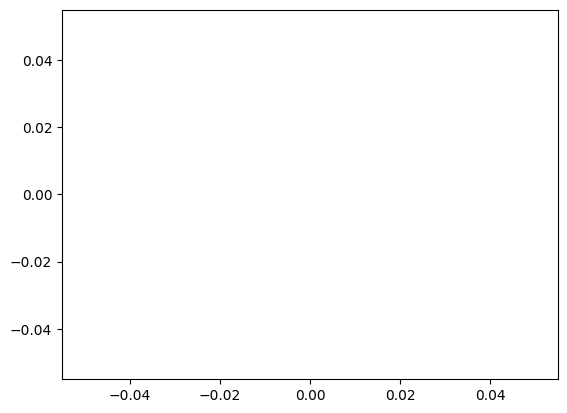

In [40]:
plt.plot(iters, train_losses)
plt.plot(iters, val_losses)
plt.show()

## Применение результата

In [41]:
model.eval()
for X, masks in val_dl:
    X = X.cuda()
    output = model(Variable(X))
    break

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
for num_item in range(len(output)):
  # num_item = 5
  image, mask, predicted = X[num_item],  masks[num_item], output[num_item, 1]
  plt.figure(figsize=(12,4))
  plt.subplot(131)
  plt.imshow(image.permute(1,2,0).cpu())
  plt.subplot(132)
  plt.imshow(mask.cpu(), cmap='gray')
  plt.subplot(133)
  plt.imshow(predicted.data.cpu().numpy(), cmap='gray')
  plt.show()

In [ ]:
num_item = 5
image, mask, predicted = X[num_item],  masks[num_item], output[num_item, 1]
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(image.permute(1,2,0).cpu())
plt.subplot(132)
plt.imshow(mask.cpu(), cmap='gray')
plt.subplot(133)
plt.imshow(predicted.data.cpu().numpy(), cmap='gray')
plt.show()